In [1]:
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

from dataset import read_word_list, pairs
from datastructures import WordIndexedSparseMatrix, Classes

In [2]:
def mi(clr, cl, cr, N):
    '''Computes the Mutual Information using bigram and marginal unigram counts'''
    if clr == 0:
        return 0
    return clr / N * np.log2(clr * N / (cl * cr))

In [3]:
def compute_loss(a, b, bigram_counts, left_unigram_counts, right_unigram_counts, s, q, N):
    '''Computes Mutual Information Loss for given merge candidate words `a` and `b`'''
    Lab = s[a] + s[b] - q[a, b] - q[b, a]
    
    # q(a+b, a+b)
    AB_bigram_count = bigram_counts[a, a] + bigram_counts[a, b] + bigram_counts[b, a] + bigram_counts[b, b]
    AB_left_unigram_count = left_unigram_counts[a] + left_unigram_counts[b]
    AB_right_unigram_count = right_unigram_counts[a] + right_unigram_counts[b]
    Lab -= mi(AB_bigram_count, AB_left_unigram_count, AB_right_unigram_count, N)
    
    # q(l, a+b)
    left_nonzero_words = bigram_counts.union_keys(a, b, "column")
    for l in left_nonzero_words:
        if l == a or l == b:
            continue

        AB_bigram_count = bigram_counts[l, a] + bigram_counts[l, b]
        Lab -= mi(AB_bigram_count, left_unigram_counts[l], AB_right_unigram_count, N)
    
    # q(a+b, r)
    right_nonzero_words = bigram_counts.union_keys(a, b, "row")
    for r in right_nonzero_words:
        if r == a or r == b:
            continue

        AB_bigram_count = bigram_counts[a, r] + bigram_counts[b, r]
        Lab -= mi(AB_bigram_count, AB_left_unigram_count, right_unigram_counts[r], N)
    
    return Lab

In [4]:
def compute_full_hierarchy(data_path, input_data_type, occurence_threshold=10, line_limit=8000, save_class_members_at_k=15):
    # Load the list of lines
    line_list = read_word_list(data_path)
    word_list = [word.split("/", 1)[input_data_type] for word in line_list]

    # Process first 8000 words
    word_list = word_list[:line_limit]

    # Create vocabulary using the word list
    # vocabulary = {word: idx for idx, word in enumerate(set(word_list))}

    # Create list of bigrams
    bigram_list = list(pairs(word_list, distance=1))
    bigram_list_mapped = bigram_list

    # Find N most common words and prepare the initial word classes
    _unigram_counts = Counter(word_list)
    _classes_list = [word for word, count in _unigram_counts.items() if count >= occurence_threshold]
    _classes_list = sorted(_classes_list)
    classes = Classes(_classes_list)

    N = len(bigram_list)

    # For logging the merges
    merge_history = []

    k = len(classes.get_unique_classes())
    while k > 1:
        # Go through the bigrams and change the words to word classes
        bigram_list_mapped = list(map(classes.map_bigram_to_classes, bigram_list_mapped))

        # Count the bigrams and left/right marginal counts
        left_unigram_counts = Counter(l for l,r in bigram_list_mapped)
        right_unigram_counts = Counter(r for l,r in bigram_list_mapped)
        bigram_counts = WordIndexedSparseMatrix.from_bigram_list(bigram_list_mapped)

        # Compute the q_k subterms
        q = WordIndexedSparseMatrix()
        for lword, rword in bigram_counts.keys():
            q[lword, rword] = mi(bigram_counts[lword, rword], left_unigram_counts[lword], right_unigram_counts[rword], N)

        # Compute the Mutual Information of the data
        total_mi = sum(mi for mi in q.values())

        # Compute the s_k subterms
        s = {}
        for a in left_unigram_counts:
            s[a] = sum(q.get_sparse_row(a).values()) + sum(q.get_sparse_column(a).values()) - q[a, a]

        # Find the merging class pair candidate
        min_Lab = None
        min_a = None
        min_b = None
        
        unique_classes = classes.get_unique_classes()
        for i, a in enumerate(unique_classes):
            for b in unique_classes[i+1:]:
                Lab = compute_loss(a, b, bigram_counts, left_unigram_counts, right_unigram_counts, s, q, N)

                if min_Lab is None or min_Lab > Lab:
                    min_Lab = Lab
                    min_a = a
                    min_b = b

        classes.merge_classes(min_a, min_b)
        k -= 1

        if k == save_class_members_at_k:
            class_members = classes.get_class_members()

        merge_history.append({
            "word A": min_a,
            "word B": min_b,
            "loss": min_Lab,
            "total mi": total_mi
        })
    return merge_history, class_members

In [5]:
from IPython.core.display import display, HTML
from graphviz import Digraph


def display_experiment(experiment_name, merge_history, class_members):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_colwidth', None)
    pd.set_option('float_format', '{:,.14f}'.format)

    display(HTML(f'<h1>{experiment_name} Results</h1>'))
    display(HTML(f'<h2>Merge history</h2>'))
    display(pd.DataFrame(merge_history))
    if class_members is not None:
        display(HTML(f'<h2>Class members for 15 classes</h2>'))
        display(pd.DataFrame({
            "class name": class_members.keys(),
            "members":  class_members.values()
        }))
    display(HTML(f'<h2>Class merge tree visualization</h2>'))
    # Create Digraph object
    dot = Digraph(experiment_name)
    dot.attr(rankdir='LR')
    for step in merge_history:
        w1 = id1 = step["word A"]
        w2 = id2 = step["word B"]
        idfix = {":": "<colon>", " ": "<space>", "Z:-------------":"Z-------"}
        id1 = idfix[id1] if id1 in idfix else id1
        id2 = idfix[id2] if id2 in idfix else id2
            
        dot.node(id1, w1)
        dot.node(id2, w2)
        dot.edge(id1, id2)
    dot.render(directory='merge_trees').replace('\\', '/')
    display(dot)

# Word Classes
Compute a full class hierarchy of words using the first 8,000 words of those data, and only for words occurring 10 times or more (use the same setting for both languages). Ignore the other words for building the classes, but keep them in the data for the bigram counts and all the formulas that use them (including the Mutual Information, the interim sums in the "Tricks", etc.). For details on the algorithm, use the Brown et al. paper available form SIS; some formulas are wrong in the paper, however, so please see the corrections in the slides (formulas for Trick #4). Note the history of the merges, and attach it to your homework. Now run the same algorithm again, but stop when reaching 15 classes. Print out all the members of your 15 classes and attach them too.

,word A,word B,loss,total mi
0,case,subject,0.00219684113872,4.99633675507534
1,cannot,may,0.00266947319525,4.99413991393662
2,structure,individuals,0.00267514354556,4.99147044074137
3,It,there,0.00347983534987,4.98879529719582
4,less,even,0.00365609607424,4.98531546184595
5,variation,nature,0.00369141204672,4.98165936577171
6,shall,see,0.00389828314153,4.97796795372499
7,slight,short,0.00390612732815,4.97406967058345
8,distinct,certain,0.00399265587590,4.97016354325531
9,manner,such,0.00424193952356,4.96617088737941


,class name,members
0,and,"[(, and, as, but, for, if, or, than, when]"
1,varieties,"[), animals, breeds, case, cases, conditions, facts, individuals, nature, plants, races, species, state, structure, subject, variation, varieties]"
2,",","[,]"
3,.,[.]
4,in,"[:, at, between, from, in, me, on, only, under]"
5,The,"[;, In, The, are]"
6,I,"[I, It, it, there, they, we]"
7,any,"[a, any, each, some, their, these, very]"
8,which,"[all, by, differ, how, much, nearly, that, this, what, which, with]"
9,more,"[an, certain, different, distinct, domestic, domesticated, even, great, its, less, long, manner, many, more, most, my, one, other, our, same, several, short, slight, such, wild]"


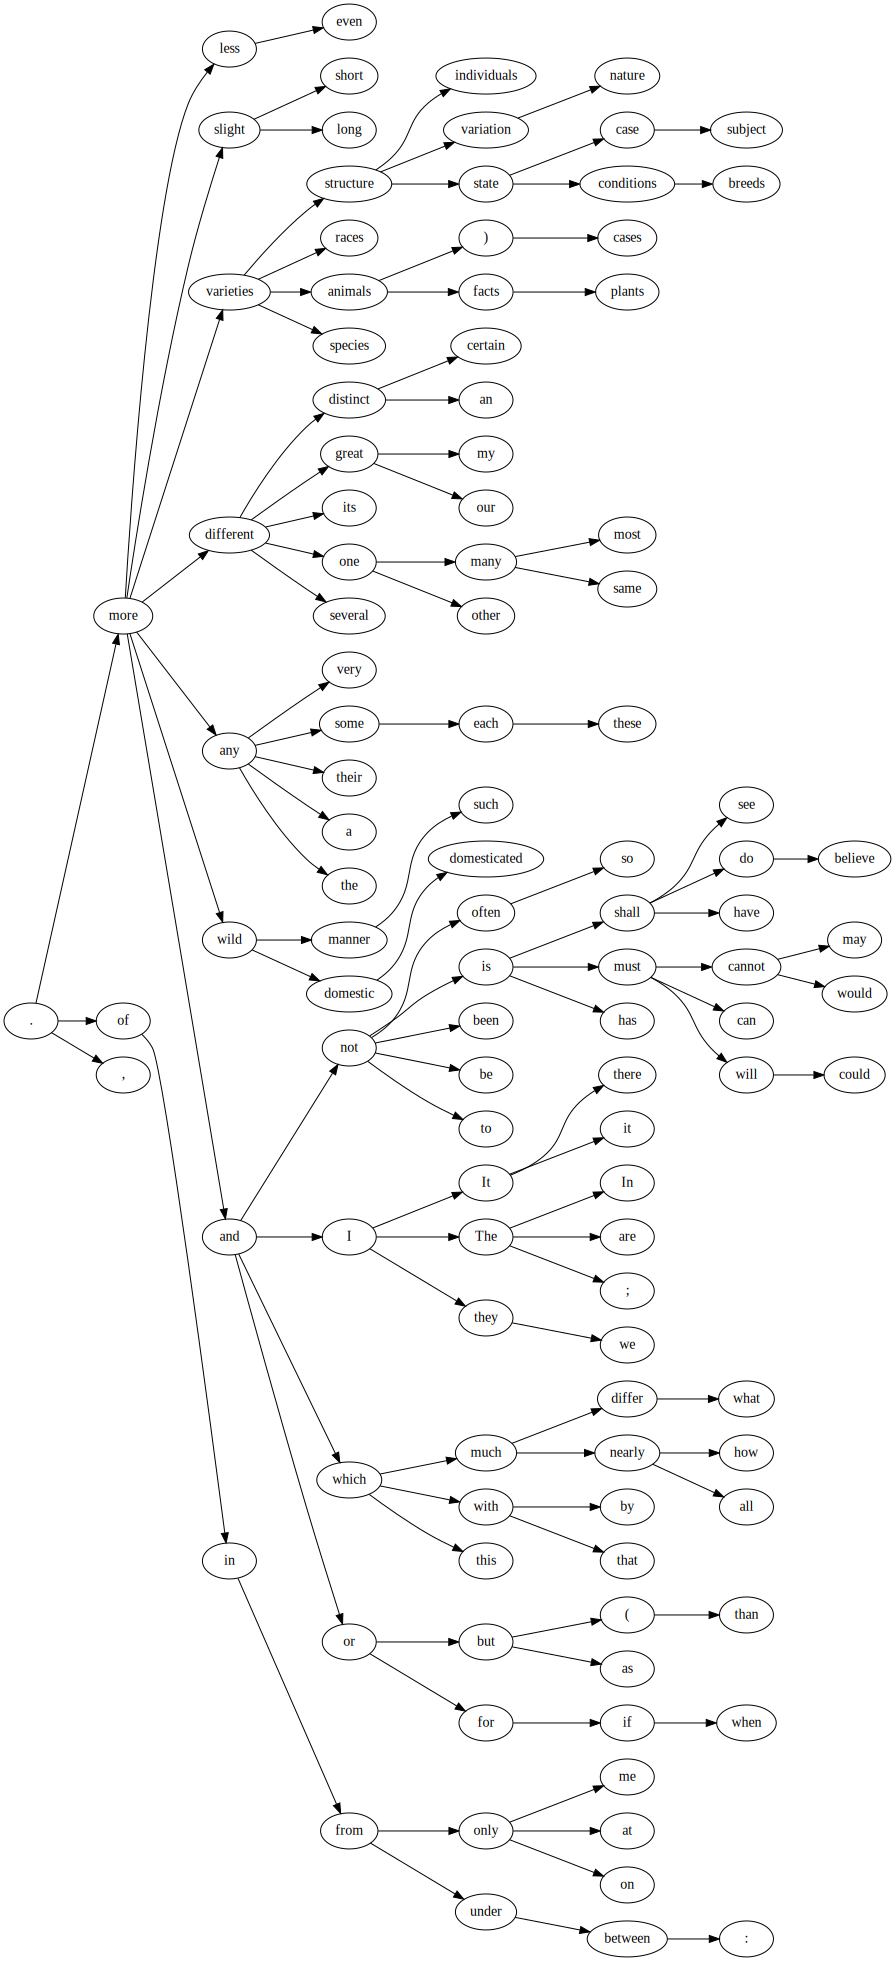

CPU times: user 1min 7s, sys: 28.6 ms, total: 1min 7s
Wall time: 1min 8s


In [6]:
%%time
merge_history, class_members = compute_full_hierarchy("data/TEXTEN1.ptg", 0, occurence_threshold=10, line_limit=8000, save_class_members_at_k=15)
display_experiment("English words", merge_history, class_members)

In [31]:
%%time
merge_history, class_members_k15 = compute_full_hierarchy("data/TEXTCZ1.ptg", 0, occurence_threshold=10, line_limit=8000, save_class_members_at_k=15)
display_experiment("Czech words", merge_history, class_members_k15)

,word A,word B,loss,total mi
0,OKD,listopadu,0.00308326967931,7.55796422078146
1,které,který,0.00337385337384,7.55488095110215
2,státu,J,0.00402546955122,7.55150709772831
3,bude,musí,0.00442215293517,7.54748162817709
4,ale,aby,0.00460435822410,7.54305947524192
5,nás,bylo,0.00464762929701,7.53845511701782
6,už,si,0.00499203328528,7.53380748772081
7,být,pouze,0.00514843941107,7.52881545443553
8,však,mezi,0.00547059279321,7.52366701502446
9,&slash;,NATO,0.00556197337113,7.51819642223125


,class name,members
0,OKD,"["", Na, OKD, V, listopadu]"
1,byl,"[&slash;, (, ), J, NATO, byl, jsou, státu, ČSFR]"
2,",","[,]"
3,-,"[-, :, být, jeho, pouze, ze]"
4,.,[.]
5,ve,"[?, před, s, ve]"
6,a,[a]
7,ale,"[aby, ale, které, který, že]"
8,bude,"[bude, do, mezi, musí, od, si, u, už, však, za]"
9,k,"[budou, jako, k, při, to, zákona]"


CPU times: user 17.2 s, sys: 6.63 ms, total: 17.2 s
Wall time: 17.4 s


# Tag Classes

Use the same original data as above, but this time, you will compute the classes for tags (the strings after slashes). Compute tag classes for all tags appearing 5 times or more in the data. Use as much data as time allows. You will be graded relative to the other student's results. Again, note the full history of merges, and attach it to your homework. Pick three interesting classes as the algorithm goes (English data only; Czech optional), and comment on them (why you think you see those tags there together (or not), etc.).

,word A,word B,loss,total mi
0,P4FS1----------,P4YS1----------,0.00052488241818,2.40619692313184
1,P4FP1----------,P4NS1----------,0.00081426585598,2.40567204071366
2,NNFXX-----A---8,Cn-S1----------,0.00083757657880,2.40485777485768
3,PQ--1----------,PQ--4----------,0.00100012501563,2.40402019827887
4,NNMXX-----A---8,Db------------8,0.00116792524132,2.40302007326325
5,Cn-P2----------,ClXP2----------,0.00127344635488,2.40185214802193
6,VpQW---XR-AA--1,CrFS1----------,0.00139333004472,2.40057870166705
7,AAMP7----1A----,AAIP7----1A----,0.00150018752344,2.39918537162233
8,PDXP2----------,PP-P2--1-------,0.00151685550181,2.39768518409889
9,VpYS---XR-AA--1,AAIS3----1A----,0.00153256959346,2.39616832859708


,class name,members
0,AANP1----1A----,"[AAFP1----1A----, AAFS1----1A----, AAIS1----1A----, AAMP1----1A----, AAMS2----1A----, AANP1----1A----, AANS1----1A----, ClFS1----------, ClHP1----------, CrFS1----------, NNIP1-----A----, NNMS3-----A----, PDFS1----------, PDYS1----------, PLMP1----------, VpQW---XR-AA--1, VpTP---XR-AA--1, VsTP---XX-AP---]"
1,PDZS2----------,"[AAFP2----1A----, AAIP2----1A----, AAMP2----1A----, ClXP2----------, Cn-P2----------, NNFPX-----A----, NNFS2-----A----, NNIS2-----A----, NNNS2-----A----, PDXP2----------, PDZS2----------, PP-P2--1-------]"
2,NNIS4-----A----,"[AAFP4----1A----, AAIP4----1A----, AANS4----1A----, NNFP3-----A----, NNFP4-----A----, NNFS3-----A----, NNFS4-----A----, NNIP3-----A----, NNIP4-----A----, NNIS4-----A----, NNMP4-----A----, NNMS2-----A----, NNMS4-----A----, NNNP2-----A----, NNNS3-----A----, NNNS4-----A----]"
3,NNIS7-----A----,"[AAFP7----1A----, AAIP6----1A----, AAIP7----1A----, AAMP7----1A----, NNFP6-----A----, NNFP7-----A----, NNFS7-----A----, NNIP6-----A----, NNIP7-----A----, NNIS7-----A----, NNMP7-----A----, NNNS7-----A----]"
4,AAIS2----1A----,"[AAFS2----1A----, AAIS2----1A----, AANS2----1A----, PSXXXZS3-------, RR--2----------, RV--2----------]"
5,AAMP4----1A----,"[AAFS4----1A----, AAIS4----1A----, AAMP4----1A----, AANP2----1A----, AANS3----1A----, Cn-S4----------, RR--3----------, RR--4----------, RV--3----------, Vf--------A----]"
6,AAFS6----1A----,"[AAFS6----1A----, AAIS6----1A----, AANS6----1A----, PDZS6----------]"
7,RR--7----------,"[AAFS7----1A----, AAIS7----1A----, AANS7----1A----, RR--7----------, RV--7----------]"
8,Xx-------------,"[AAIP1----1A----, AAIS3----1A----, AGFS1-----A----, Db-------------, Db------------1, Dg-------1A----, Dg-------2A----, J,-------------, J,-X---3-------, NNIS3-----A----, NNNP1-----A----, P4FP1----------, P4FS1----------, P4NS1----------, P4YS1----------, P7-X3----------, P7-X4----------, PDNS1----------, PDNS4----------, PP-P4--1-------, PQ--1----------, PQ--4----------, PSXXXXP3-------, TT-------------, VB-P---3P-NA---, VB-S---1P-AA---, Vc-X---3-------, VpNS---XR-NA---, VpYS---XR-AA--1, VsYS---XX-AP---, Xx-------------]"
9,NNIP2-----A----,"[AAMS1----1A----, AAXXX----1A----, C=-------------, Cn-S1----------, C}-------------, Db------------8, NNFP2-----A----, NNFXX-----A----, NNFXX-----A---8, NNIP2-----A----, NNIXX-----A---8, NNMP2-----A----, NNMP3-----A----, NNMS1-----A----, NNMS7-----A----, NNMXX-----A---8, NNNXX-----A----, PDZS3----------, VsNS---XX-AP---, VsQW---XX-AP---, X@-------------, XX-------------]"


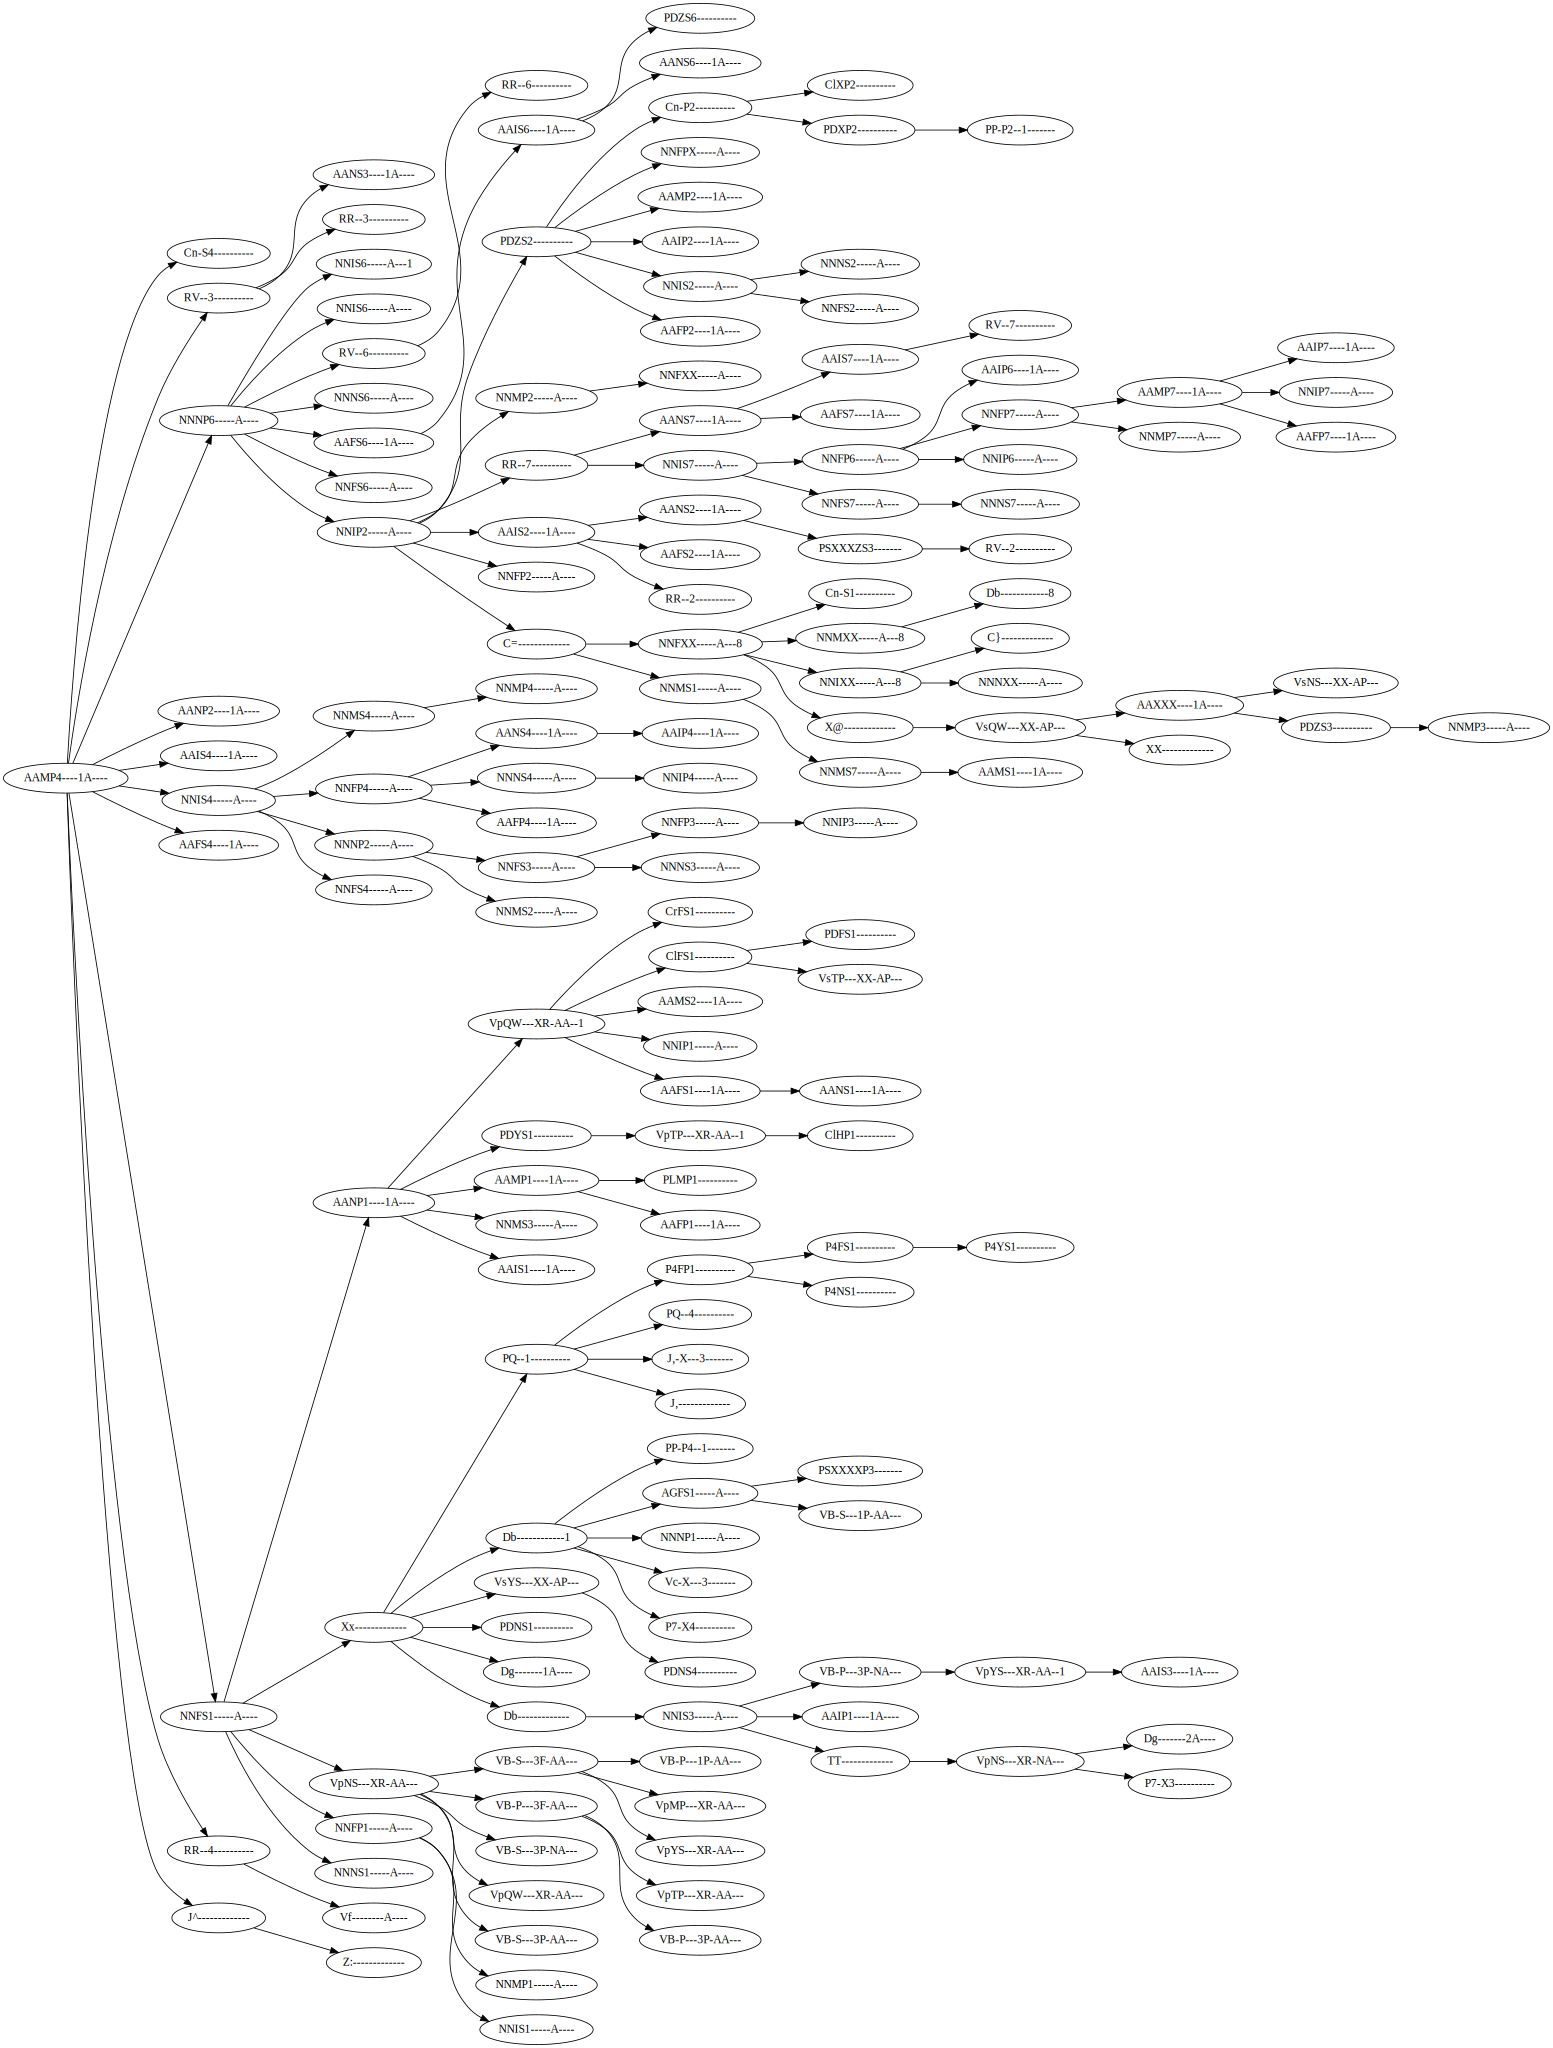

CPU times: user 1min 33s, sys: 32.9 ms, total: 1min 33s
Wall time: 1min 34s


In [33]:
%%time
merge_history, class_members_k15 = compute_full_hierarchy("data/TEXTCZ1.ptg", 1, occurence_threshold=5, line_limit=8000, save_class_members_at_k=15)
display_experiment("Czech tags", merge_history, class_members_k15)

,word A,word B,loss,total mi
0,WP$,RBR,0.00021893989181,0.88331683271931
1,WP$,JJR,0.00034888337197,0.88309789282750
2,NNPS,SYM,0.00081936225086,0.88274900945553
3,PRP,EX,0.00108471004269,0.88192964720467
4,FW,NNP,0.00121859340867,0.88084493716198
5,.,(,0.00131693737066,0.87962634375331
6,WP,"""",0.00138966800657,0.87830940638265
7,JJ,JJS,0.00173691032387,0.87691973837608
8,RBS,WP$,0.00210760590792,0.87518282805221
9,WP,WRB,0.00230763097157,0.87307522214430


,class name,members
0,VBG,"["", VBG, WDT, WP, WRB]"
1,",","[(, ,, ., :]"
2,CC,[CC]
3,RBS,"[CD, JJ, JJR, JJS, RBR, RBS, WP$]"
4,DT,"[DT, PRP$]"
5,PRP,"[EX, PRP]"
6,FW,"[FW, NNP, NNPS, SYM]"
7,IN,[IN]
8,MD,[MD]
9,NNS,"[NN, NNS]"


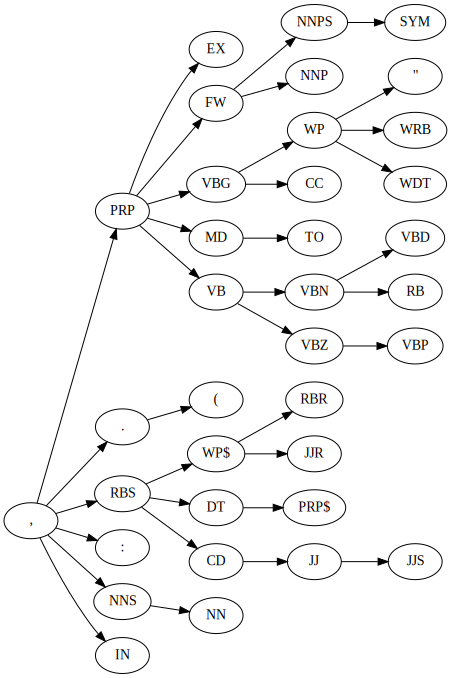

CPU times: user 10.8 s, sys: 86.4 ms, total: 10.9 s
Wall time: 11.1 s


In [34]:
%%time
merge_history, class_members_k15 = compute_full_hierarchy("data/TEXTEN1.ptg", 1, occurence_threshold=5, line_limit=999999, save_class_members_at_k=15)
display_experiment("English tags", merge_history, class_members_k15)